# Introducción

Este cuaderno tiene como objetivo documentar el proceso de predicción de precios de arriendo de apartamentos en la ciudad de Ibagué, utilizando algoritmos de machine learning. A lo largo del análisis, se realiza una exhaustiva ingeniería de características para transformar y adecuar los datos, así como la imputación de valores faltantes y la depuración de la información. Todo esto permite construir un conjunto de datos robusto y confiable, que facilita la obtención de resultados precisos y útiles para la toma de decisiones en el mercado inmobiliario local.

Los datos analizados provienen de la recopilación más actualizada realizada mediante técnicas de web scraping, usando la plataforma Finca Raíz, cuyo proceso y consideraciones se encuentran detalladamente descritos en el archivo `01_WSFincaRaizIbague.ipynb`. Esta información constituye la base para el desarrollo y validación de los modelos predictivos presentados a continuación.

# Preparación del entorno de trabajo

Se realiza la carga de las librerías necesarias:

In [84]:
# procesamiento de datos
import pandas as pd
import numpy as np
import math

# visualización de datos
import seaborn as sns
import matplotlib.pyplot as plt

# transformación de datos
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

# machine learning
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

# evaluación de modelos
from sklearn.metrics import mean_squared_error, r2_score

# manejo de fechas
from datetime import datetime
import os

# manejo de advertencias
import warnings

Se define de fecha más reciente de la información descargada.

In [85]:
# búsqueda del archivo más reciente en la carpeta 'datos'
carpeta_datos = 'datos'
archivos_apartamentos = [f for f in os.listdir(carpeta_datos) if f.endswith('_apartamentos_ibague.parquet')]
if archivos_apartamentos:
    # Encontrar el archivo con la fecha de modificación más reciente
    archivo_mas_reciente = max(archivos_apartamentos, key=lambda f: os.path.getmtime(os.path.join(carpeta_datos, f)))
    fecha_actual = datetime.fromtimestamp(os.path.getmtime(os.path.join(carpeta_datos, archivo_mas_reciente))).strftime('%Y%m%d')
else:
    fecha_actual = None  # No se encontró el archivo
# impresión del resultado
if fecha_actual:
    print(fecha_actual[:4] + '-' + fecha_actual[4:6] + '-' + fecha_actual[6:8])
else:
    print("No se encontró archivo de apartamentos en la carpeta 'datos'.")

2025-09-22


Finalmente, se desactivan las advertencias para evitar que se muestren mensajes innecesarios durante la ejecución del código:

In [86]:
warnings.filterwarnings('ignore')

# Preparación de datos

Se inicia con la importación de la información:

In [87]:
# lectura de datos
datos_apartamentos = pd.read_parquet(f'datos/{fecha_actual}_apartamentos_ibague.parquet')
# revisión de observaciones al azar
datos_apartamentos.sample(10, random_state=42)

,Identificador,Área Construida (metros cuadrados),Área Privada (metros cuadrados),Habitaciones,Baños,Estrato,Parqueaderos,Antigüedad,Administración,Piso N°,Estado,Cantidad de pisos,Latitud,Longitud,Precio
44,191180666,232.0,232.0,5,4,4,2,16 a 30 años,NaN,7,Usado,7,4.444440,-75.240016,3200000
47,192859122,60.0,NaN,3,2,2,1,1 a 8 años,NaN,10,Usado,<NA>,4.449624,-75.143888,600000
4,192755337,58.0,58.0,2,1,3,<NA>,16 a 30 años,140000.0,<NA>,Usado,<NA>,4.440667,-75.198977,760000
55,192829838,170.0,170.0,4,3,4,2,1 a 8 años,NaN,11,Usado,<NA>,4.441244,-75.201267,4500000
26,192371808,60.0,56.0,1,2,4,1,1 a 8 años,NaN,6,Usado,<NA>,4.438916,-75.198926,3500000
64,192861063,51.0,51.0,3,2,3,<NA>,1 a 8 años,189100.0,<NA>,Usado,<NA>,4.419986,-75.170502,972000
73,192884964,74.0,NaN,3,2,4,1,1 a 8 años,NaN,12,Usado,<NA>,4.431127,-75.180289,1500000
10,191344849,44.0,44.0,3,2,3,<NA>,9 a 15 años,138000.0,<NA>,None,<NA>,4.451767,-75.141645,562000
40,192669238,53.0,53.0,3,2,3,1,9 a 15 años,NaN,7,Usado,<NA>,4.447021,-75.152942,880000
108,192712224,60.0,60.0,2,2,4,1,16 a 30 años,242000.0,<NA>,Usado,<NA>,4.440267,-75.205204,1258000


## Análisis exploratorio de datos

Se revisa la información general de la base:

In [88]:
datos_apartamentos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Identificador                       121 non-null    object 
 1   Área Construida (metros cuadrados)  121 non-null    float64
 2   Área Privada (metros cuadrados)     92 non-null     float64
 3   Habitaciones                        120 non-null    Int64  
 4   Baños                               120 non-null    Int64  
 5   Estrato                             121 non-null    object 
 6   Parqueaderos                        81 non-null     Int64  
 7   Antigüedad                          110 non-null    object 
 8   Administración                      47 non-null     float64
 9   Piso N°                             55 non-null     Int64  
 10  Estado                              97 non-null     object 
 11  Cantidad de pisos                   8 non-nul

Se evidencia la presencia de valores faltantes en varias columnas. Para más detalle, se calcula el porcentaje de valores faltantes por cada columna que tuvo un mínimo de 1 faltante:

In [89]:
porcentaje_faltantes = (datos_apartamentos.isnull().sum() / len(datos_apartamentos)) * 100
pd.DataFrame(
    porcentaje_faltantes[porcentaje_faltantes > 0].apply(lambda x: f"{x:.2f}"),
    columns=['Porcentaje de Faltantes']
).rename_axis('Variable').sort_values(by='Porcentaje de Faltantes', ascending=False)

,Porcentaje de Faltantes
Variable,
Cantidad de pisos,93.39
Antigüedad,9.09
Administración,61.16
Piso N°,54.55
Parqueaderos,33.06
Área Privada (metros cuadrados),23.97
Estado,19.83
Habitaciones,0.83
Baños,0.83


Se observa lo siguiente:

- `Área Privada (metros cuadrados)` tiene valores faltantes, mientras que `Área Construida (metros cuadrados)` no, por lo que puede ser viable excluirla del análisis.
- `Parqueaderos` es, probablemente, una variable con muy poca variabilidad, por lo que también puede excluirse, eventualmente.
- `Antigüedad` tiene muy pocos valores faltantes, por lo que puede ser viable una imputación. Desde luego, considerando que se trata de una variable categórica, al final se terminará transformado.
- `Piso N°` tiene un porcentaje muy alto de valores faltantes, por lo que puede excluirse.
- `Estado` tiene una situación similar a la variable anterior.
- `Cantidad de pisos` tiene un porcentaje de faltantes alto, por lo que también es viable exluirlo.

Ya se revisarán en detalle las variables. Por el momento, se revisa que no existan filas duplicadas:

In [90]:
print(f'Hay {datos_apartamentos.duplicated().sum()} filas duplicadas.')

Hay 0 filas duplicadas.


A continuación, se definen las variables numéricas y categóricas desde el punto de vista conceptual. Es decir, se hace la clasificación que tiene sentido desde el punto de vista económico más allá de la lectura que hace Python:

In [91]:
variables_numericas=[
    'Área Construida (metros cuadrados)', 'Área Privada (metros cuadrados)', 'Habitaciones',
    'Baños', 'Parqueaderos', 'Administración', 'Cantidad de pisos', 'Latitud', 'Longitud', 'Precio'
]
variables_categoricas = [col for col in datos_apartamentos.columns if col not in variables_numericas and col != 'Identificador']

De esta forma, se inicia con la revisión de las variables categóricas:

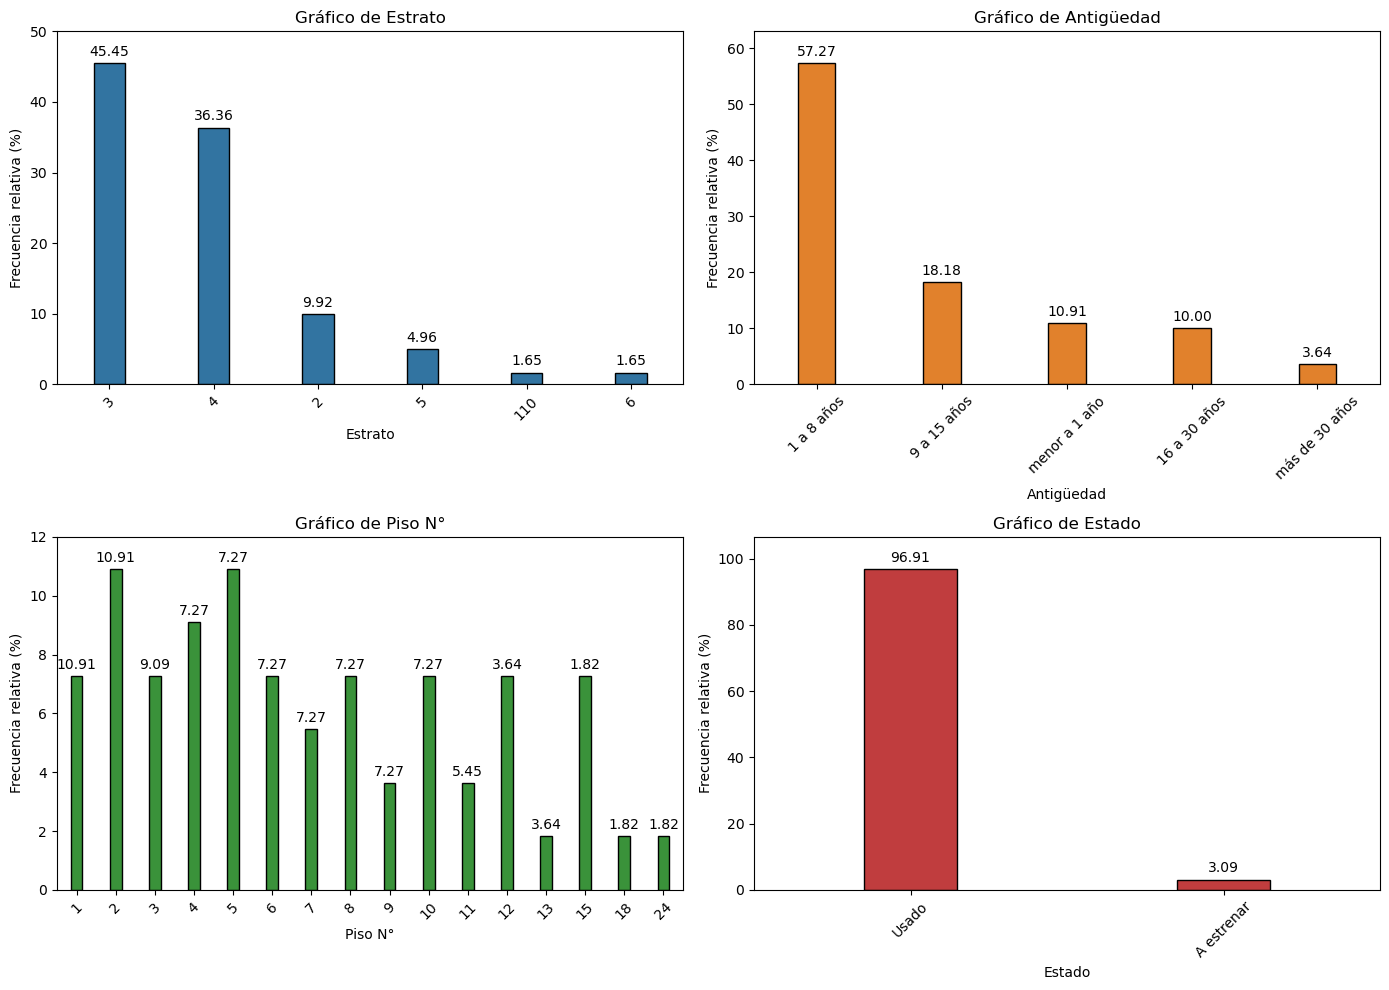

In [92]:
# determinación del número de variables categóricas
n_vars = len(variables_categoricas)
n_cols = 2
n_rows = math.ceil(n_vars / n_cols)

# configuración de la figura
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
axes = axes.flatten()

# paleta con tantos colores como variables
palette = sns.color_palette("tab10", n_vars)

# creación de los gráficos
for i, var in enumerate(variables_categoricas):
    ax = axes[i]
    # cálculo de la frecuencia relativa
    freq_rel = datos_apartamentos[var].value_counts(normalize=True) * 100
    orden = freq_rel.index
    # graficación de la frecuencia relativa (un solo color por variable)
    g = sns.barplot(
        x=orden, 
        y=freq_rel.values, 
        ax=ax, 
        width=0.3, 
        color=palette[i], 
        edgecolor='#000000'
    )
    ax.set_title(f'Gráfico de {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Frecuencia relativa (%)')
    ax.tick_params(axis='x', rotation=45)

    # cálculo del valor máximo de las barras
    max_val = freq_rel.max()

    # adición de etiquetas sobre las barras
    for p, valor in zip(g.patches, freq_rel.values):
        g.annotate(f'{valor:.2f}', 
                   (p.get_x() + p.get_width() / 2, p.get_height()),
                   ha='center', va='bottom', fontsize=10, color='black', 
                   xytext=(0, 3), textcoords='offset points')
    # ajuste del límite del eje y sumando un 10% al máximo
    ax.set_ylim(0, max_val + 0.1 * max_val)

# eliminación de ejes vacíos en caso de haberlos
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# impresión de la figura
plt.tight_layout()
plt.show()

En el caso del estrato, la mayor parte de los apartamentos pertenece a los estratos 3 y 4. Menos del 1% aparece sin información, lo que significa que es más viable realizar una imputación de esos casos de acuerdo al sector en el que se encuentre el apartamento.

En el caso de la antigüedad, la mayor parte de los apartamentos tiene de 1 a 15 años de antigüedad. Cerca del 7% de los apartamentos aparece sin información, lo que hace viable realizar una imputación de acuerdo a otras características similares.

En el número de piso del apartamento, más de la mitad de observaciones no tiene información, de forma que es mejor eliminar la variable. Una situación similar se presenta con el estado del apartamento, aunque su porcentaje de faltantes es más bajo, sigue siendo demasiado alto para considerar una imputación.

A continuación, se revisan las variables numéricas:

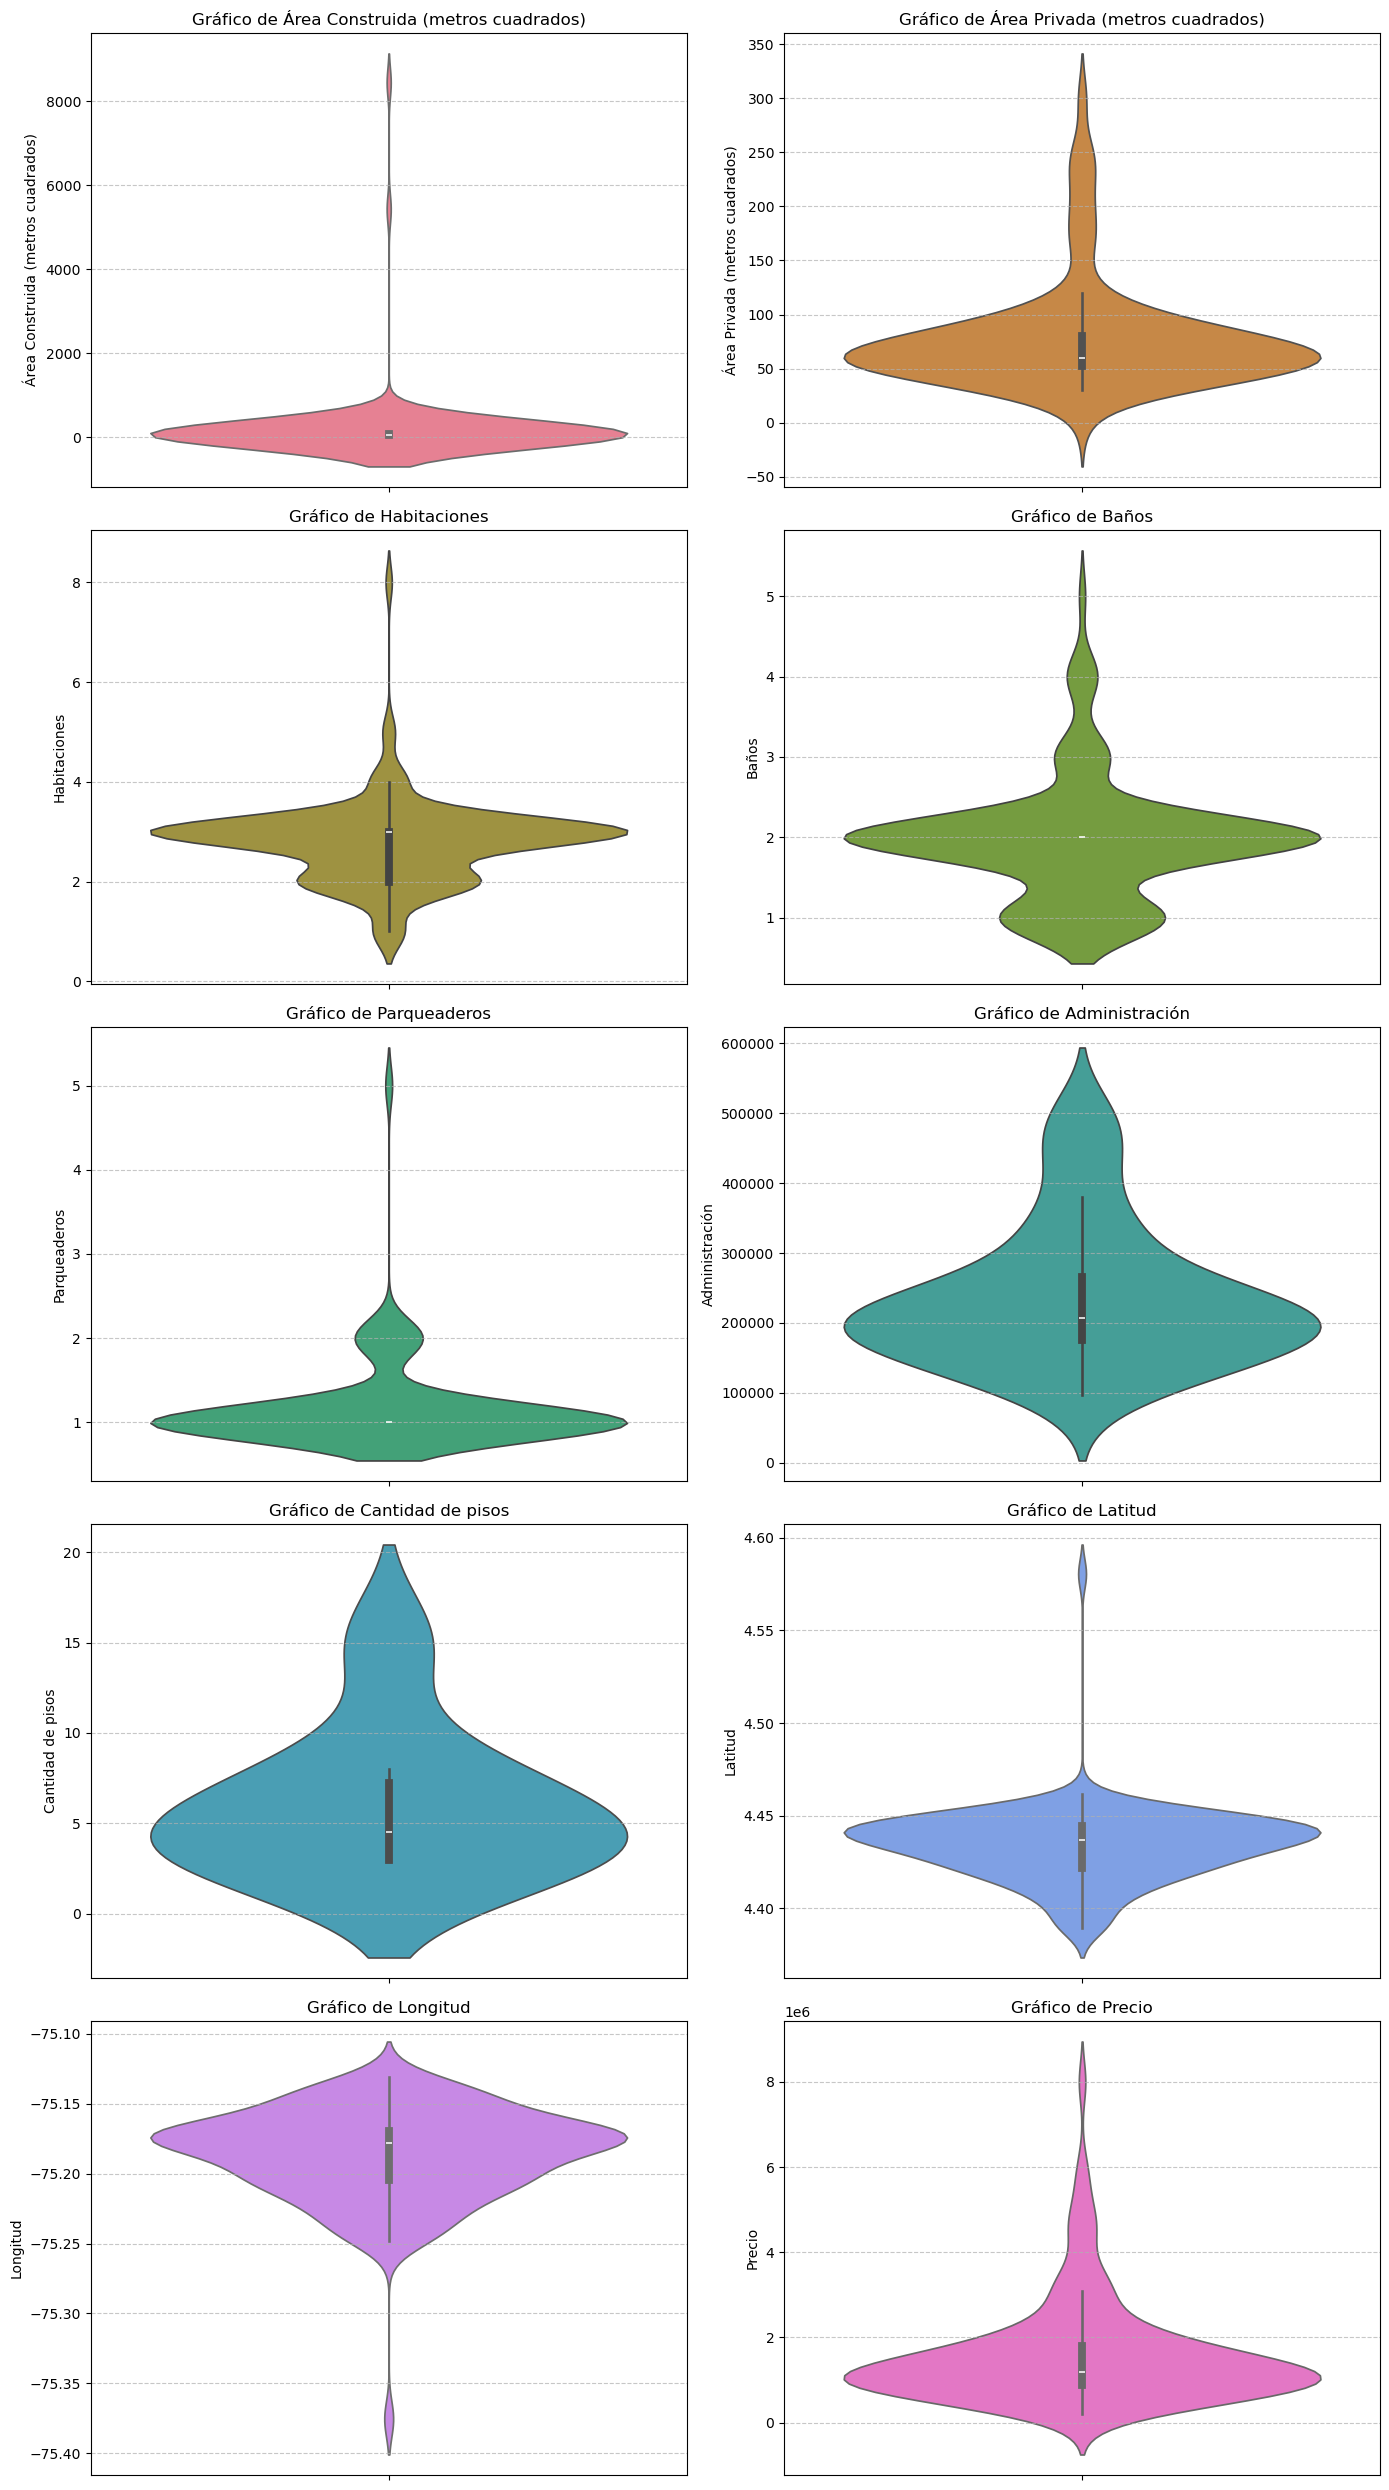

In [93]:
# determinación del número de variables numéricas
n_vars = len(variables_numericas)
n_cols = 2
n_rows = math.ceil(n_vars / n_cols)

# configuración de la figura
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
axes = axes.flatten()

# paleta con tantos colores como variables
palette = sns.color_palette("husl", n_vars)  # puedes probar "Set2", "tab10", "pastel", etc.

# creación de los violinplots para cada variable numérica
for i, var in enumerate(variables_numericas):
    ax = axes[i]
    sns.violinplot(
        y=datos_apartamentos[var],
        ax=ax,
        color=palette[i]  # un color distinto por variable
    )
    ax.set_title(f'Gráfico de {var}')
    ax.set_ylabel(var)
    ax.set_xlabel('')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# eliminación de ejes vacíos en caso de haberlos
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# impresión de la figura
plt.tight_layout()
plt.show()

Se evidencia la presencia de valores atípicos (que ya serán revisados formalmente) en las variables de área (tanto construida como privada) y parqueaderos, latitud y longitud. También sucede con el precio, aunque es ese caso es un comportamiento esperado y se recomienda escalarla en vez de buscar algún tipo de imputación.

Ahora, se revisa la correlación entre variables mediante un mapa de calor de correlaciones y el uso de diagramas de dispersión entre variables:

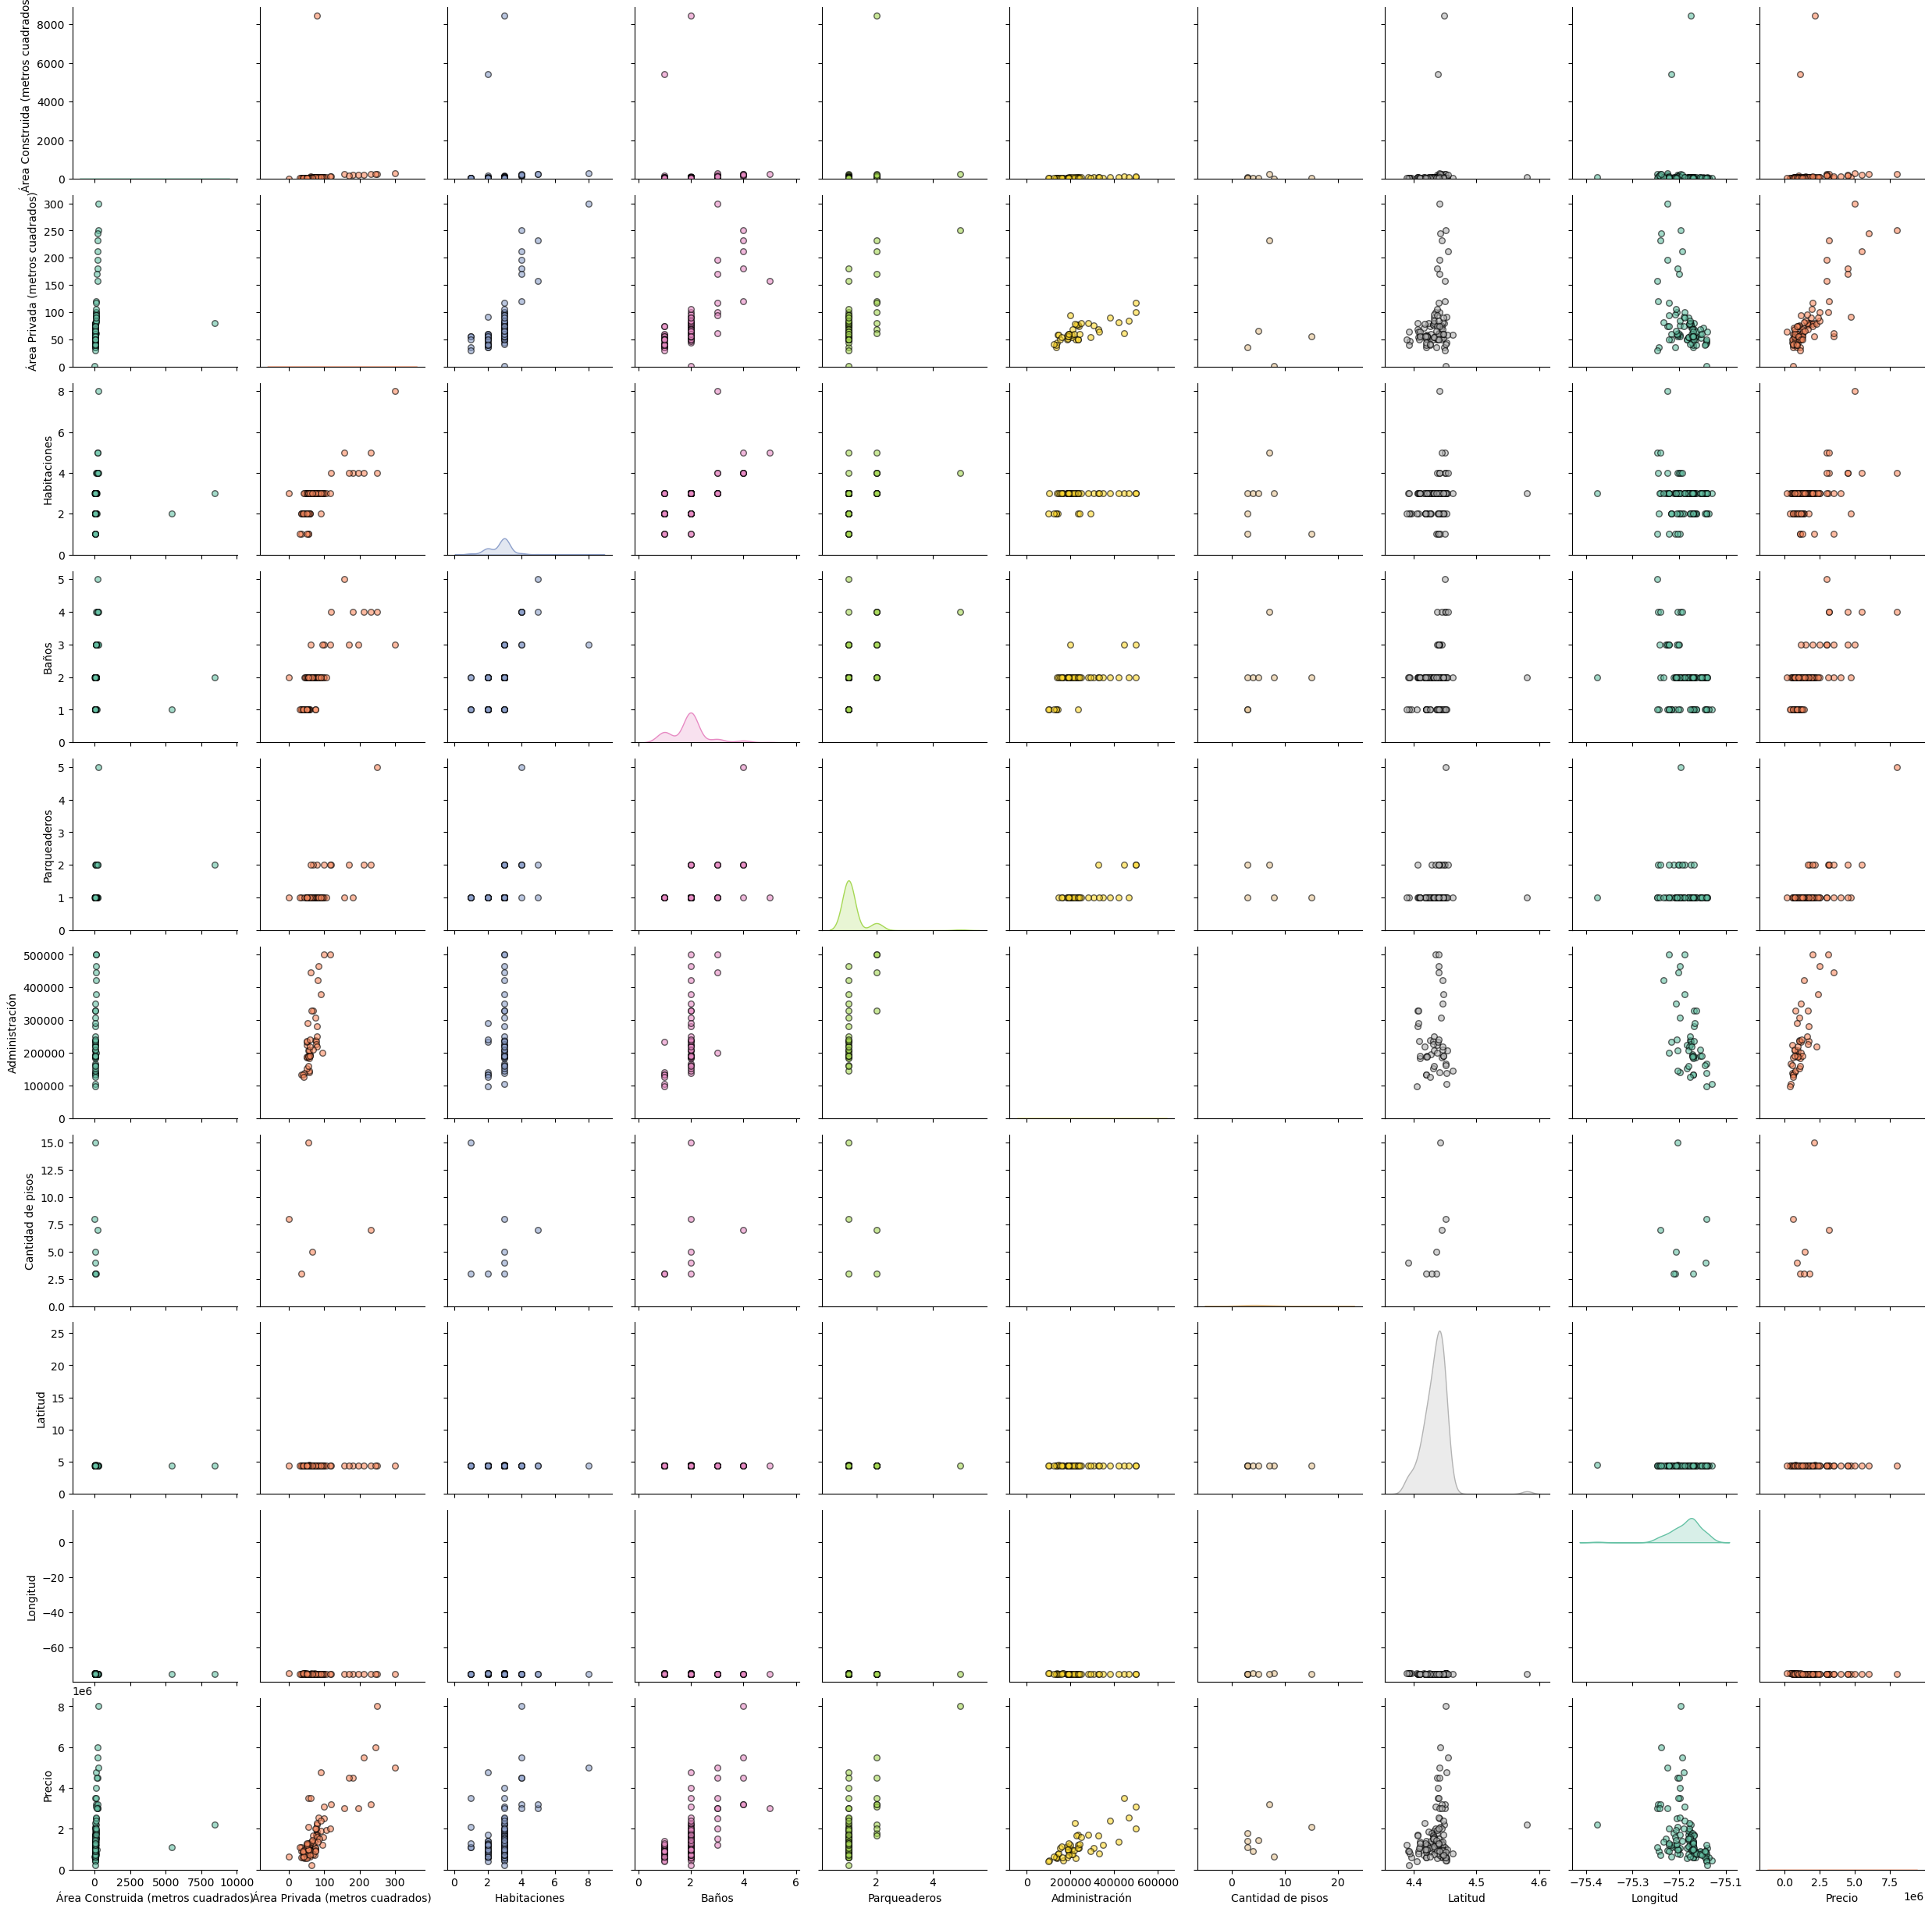

In [94]:
# paleta con un color distinto por variable
palette = sns.color_palette("Set2", len(variables_numericas))
color_dict = dict(zip(variables_numericas, palette))

# creación del PairGrid
g = sns.PairGrid(datos_apartamentos, vars=variables_numericas)

# scatterplots (usando color de la variable en el eje x, por ejemplo)
for i, x_var in enumerate(variables_numericas):
    for j, y_var in enumerate(variables_numericas):
        if i != j:  # fuera de la diagonal
            ax = g.axes[j, i]
            ax.scatter(
                datos_apartamentos[x_var],
                datos_apartamentos[y_var],
                color=color_dict[x_var], alpha=0.6, edgecolor="k", s=30
            )

# kdeplots en la diagonal con color por variable
for i, var in enumerate(variables_numericas):
    ax = g.axes[i, i]
    sns.kdeplot(datos_apartamentos[var], ax=ax, color=color_dict[var], fill=True)

plt.show()

Si no se consideran los valores atípicos, se evidencia que las áreas están muy relacionadas. Se concluye, entonces, que se puede eliminar área privada, que es la variable con más valores faltantes, pero es necesario realizar un tratamiento a los valores atípicos del área construida.

En general, la presencia de valores atípicos tiene efectos notables en la determinación de correlaciones entre variables. De ahí que muchas correlaciones sean más bien bajas. Algunas correlaciones altas son engañosas, como en el caso de cantidad de pisos y administración, pues se trata de muy pocos datos. La relación de administración con las áreas es extraña, ya que graficamente no se refleja lo mismo que el cálculo de correlación.

Con respecto a las coordenadas geográficas, se requiere una revisión adicional desde el punto de vista geográfico. La siguiente es la graficación de los puntos en el mapa:

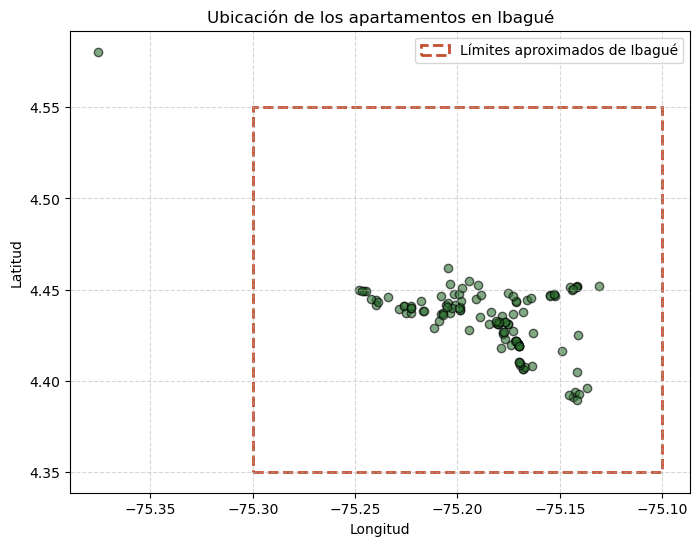

In [95]:
# definición de los límites aproximados de la ciudad
lat_min = 4.35
lat_max = 4.55
lon_min = -75.30
lon_max = -75.10

# definición de las dimensiones de la figura
plt.figure(figsize=(8, 6))
# creación de gráfico de dispersión
plt.scatter(
    datos_apartamentos['Longitud'], 
    datos_apartamentos['Latitud'], 
    c='#2E7031', 
    alpha=0.6, 
    edgecolor='k'
)

# inclusión del recuadro que enmarca los límites de la ciudad de Ibagué
plt.gca().add_patch(
    plt.Rectangle(
        (lon_min, lat_min),  # esquina inferior izquierda
        lon_max - lon_min,   # ancho
        lat_max - lat_min,   # alto
        fill=False,
        edgecolor='#C44F31',
        linewidth=2,
        linestyle='--',
        label='Límites aproximados de Ibagué'
    )
)

plt.title('Ubicación de los apartamentos en Ibagué')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


Hay un dato que claramente no fue ubicado en Ibagué. Con exactitud, se determina la proporción:

In [96]:
# definición de los límites aproximados de la ciudad
lat_min = 4.35
lat_max = 4.55
lon_min = -75.30
lon_max = -75.10

# creación de variable auxiliar que identifica apartamentos fuera de la ciudad
datos_apartamentos['fuera_ciudad'] = (
    ~(
        (datos_apartamentos['Latitud'] >= lat_min) & (datos_apartamentos['Latitud'] <= lat_max) &
        (datos_apartamentos['Longitud'] >= lon_min) & (datos_apartamentos['Longitud'] <= lon_max)
    )
).astype(int)

# cálculo de la proporción y el número absoluto
proporcion_fuera = datos_apartamentos['fuera_ciudad'].mean()
cantidad_fuera = datos_apartamentos['fuera_ciudad'].sum()

# impresión del resultado
print(f"Proporción de apartamentos fuera de Ibagué: {proporcion_fuera:.2%}")
print(f"Número absoluto de apartamentos fuera de Ibagué: {cantidad_fuera}")

Proporción de apartamentos fuera de Ibagué: 0.83%
Número absoluto de apartamentos fuera de Ibagué: 1


Debido a que la proporción y cantidad de apartamentos con coordenadas fuera de Ibagué es muy bajo, se puede eliminar las observaciones por fuera de la ciudad.

## Ingeniería de características

### Eliminación de variables

A partir del análisis exploratorio previo, en el que se detectaron variables con alta proporción de valores faltantes o que no aportaban información, se decide eliminar las siguientes variables:

In [97]:
# Eliminación de variables con alta proporción de valores faltantes o poco aporte
variables_a_eliminar = [
    'Piso N°', 'Estado', 'Cantidad de pisos', 'Área Privada (metros cuadrados)', 'Administración', 'Parqueaderos'
]
datos_apartamentos = datos_apartamentos.drop(columns=variables_a_eliminar)

# Además, eliminamos estas variables del listado de variables numéricas si están presentes
variables_numericas = [col for col in variables_numericas if col not in variables_a_eliminar]

De esta forma, la nueva estructura de la base es la siguiente:

In [98]:
datos_apartamentos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Identificador                       121 non-null    object 
 1   Área Construida (metros cuadrados)  121 non-null    float64
 2   Habitaciones                        120 non-null    Int64  
 3   Baños                               120 non-null    Int64  
 4   Estrato                             121 non-null    object 
 5   Antigüedad                          110 non-null    object 
 6   Latitud                             121 non-null    float64
 7   Longitud                            121 non-null    float64
 8   Precio                              121 non-null    int64  
 9   fuera_ciudad                        121 non-null    int64  
dtypes: Int64(2), float64(3), int64(2), object(3)
memory usage: 9.8+ KB


### Exclusión de coordenadas fuera de la ciudad

Se decide excluir los apartamentos que se encuentran fuera de la ciudad. No se recomienda realizar una imputación en estos casos. Además, la proporción de apartamentos fuera de la ciudad son muy pocos.

In [99]:
# filtro para excluir casos fuera de la ciudad
datos_apartamentos=datos_apartamentos[datos_apartamentos['fuera_ciudad']!=1]
# eliminación de la variable
del datos_apartamentos['fuera_ciudad']

### Variables categóricas

En la base quedaron las siguientes variables categóricas:

In [100]:
# identificación de variables
variables_categoricas = datos_apartamentos.select_dtypes(include=['object', 'category']).columns.tolist()
print("Variables categóricas restantes:", variables_categoricas)

Variables categóricas restantes: ['Identificador', 'Estrato', 'Antigüedad']


Aunque la variable estrato podría interpretarse de forma numérica para facilidad de uso, no es recomendable porque el salto del precio entre estratos no es igual entre los estratos bajos (p.ej. 1 y 2) y los estratos altos (p.ej. 5 y 6). Por lo tanto, se prefiere seguirlo tomando como una variable categórica. De esta forma, para las variables que quedaron, se implementa el procedimiento de one-hot encoding. Antes de hacerlo, se imputan los faltantes de información para cada variable.

#### Imputación de valores faltantes

Iniciando con la variable estrato, se inicia con la identificación de los valores faltantes.

In [101]:
# conversión de valores '101' a faltantes (variable de tipo texto)
datos_apartamentos['Estrato'] = datos_apartamentos['Estrato'].replace('110', np.nan)
# tabla de frecuencia incluyendo faltantes
pd.DataFrame(datos_apartamentos['Estrato'].value_counts(dropna=False).sort_index()).reset_index()

,Estrato,count
0,2,12
1,3,55
2,4,44
3,5,6
4,6,2
5,NaN,1


Para realizar la imputación de los valores faltantes de estrato, se utiliza el algoritmo de los _k_ vecinos más cercanos para aprovechar los datos de las coordenadas de apartamentos. Así, se asigna el estrato del apartamento más cercano.

Para determinar el número de vecinos, se revisa graficamente el comportamiento del error cuadrático medio con respecto al número de vecinos:

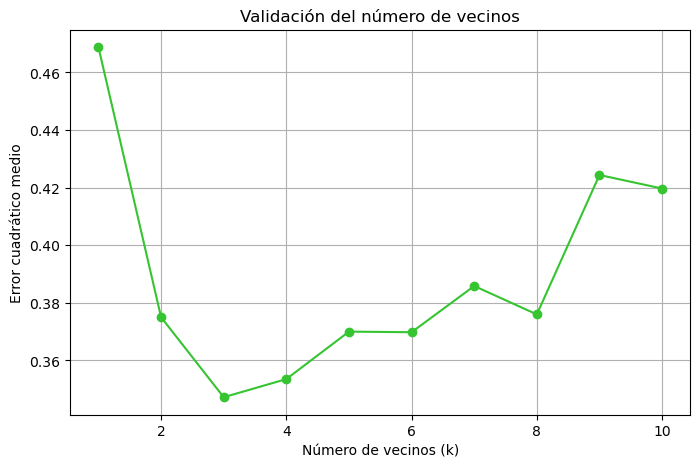

In [102]:
# conversión de casos con 'Sin información' a nulos
datos_apartamentos['Estrato'] = datos_apartamentos['Estrato'].replace('Sin información', np.nan)

# selección de las variables necesarias
datos_validacion = datos_apartamentos[['Longitud', 'Latitud', 'Estrato']].copy()
datos_validacion['Estrato'] = pd.to_numeric(datos_validacion['Estrato'], errors='coerce')

# definición del rango de vecinos a probar
vecinos_rango = range(1, 11)
errores = []

# se toma solo las filas donde Estrato no es nulo para simular el proceso de imputación
datos_no_nulos = datos_validacion.dropna(subset=['Estrato'])

# se enmascaran aleatoriamente algunos valores de 'Estrato' para validar el error de imputación
np.random.seed(42)
mask = np.random.rand(len(datos_no_nulos)) < 0.2
datos_no_nulos_masked = datos_no_nulos.copy()
datos_no_nulos_masked.loc[mask, 'Estrato'] = np.nan

# cálculo del error para cada número de vecinos
for k in vecinos_rango:
    imputer = KNNImputer(n_neighbors=k)
    imputados = imputer.fit_transform(datos_no_nulos_masked)
    # Solo se evalúan los valores que fueron enmascarados
    valores_reales = datos_no_nulos['Estrato'].values[mask]
    valores_imputados = imputados[mask, 2]
    # Error cuadrático medio
    error = np.mean((valores_reales - valores_imputados) ** 2)
    errores.append(error)

plt.figure(figsize=(8,5))
plt.plot(vecinos_rango, errores, marker='o', color='#36C431')
plt.xlabel('Número de vecinos (k)')
plt.ylabel('Error cuadrático medio')
plt.title('Validación del número de vecinos')
plt.grid(True)
plt.show()

Es evidente que el error de minimiza radicalmente para 3 vecinos, por lo que se deja ese valor.

In [103]:
if datos_apartamentos['Estrato'].isna().sum() >= 1:
    # creación de un DataFrame temporal con las variables necesarias para la imputación
    datos_imputacion = datos_apartamentos[['Longitud', 'Latitud', 'Estrato']].copy()
    # conversión de la variable Estrato a numérica para el algoritmo KNN
    datos_imputacion['Estrato'] = pd.to_numeric(datos_imputacion['Estrato'], errors='coerce')
    # aplicación de la imputación con 3 vecinos
    imputer = KNNImputer(n_neighbors=3)
    datos_imputados = imputer.fit_transform(datos_imputacion)
    # actualización de la variable Estrato en el DataFrame original
    datos_apartamentos['Estrato'] = datos_imputados[:, 2]
    # conversión de vuelta a entero y luego a string para mantener el formato original
    datos_apartamentos['Estrato'] = datos_apartamentos['Estrato'].astype(int).astype(str)
    print("Imputación completada con 3 vecinos.")
else:
    print("No hay faltantes")

# impresión para revisión
pd.DataFrame(datos_apartamentos['Estrato'].value_counts(dropna=False).sort_index()).reset_index()

Imputación completada con 3 vecinos.


,Estrato,count
0,2,12
1,3,55
2,4,45
3,5,6
4,6,2


A continuación, se imputan los casos faltantes de `Antigüedad`:

In [104]:
# conversión de casos sin información a nulos
datos_apartamentos.loc[datos_apartamentos['Antigüedad'] == 'Sin información', 'Antigüedad'] = np.nan
# cálculo de la mode de antigüedad
moda_antiguedad = datos_apartamentos['Antigüedad'].mode()[0]
# imputación de nulos con la moda
datos_apartamentos['Antigüedad'] = datos_apartamentos['Antigüedad'].fillna(moda_antiguedad)
# revisión de la nueva tabla de frecuencias
pd.DataFrame(datos_apartamentos['Antigüedad'].value_counts(dropna=False).sort_index()).reset_index()

,Antigüedad,count
0,1 a 8 años,74
1,16 a 30 años,11
2,9 a 15 años,19
3,menor a 1 año,12
4,más de 30 años,4


Ya con las variables imputadas, se realizar el one-hot encoding:

In [105]:
# one hot encoding para las variables 'Estrato' y 'Antigüedad'
datos_apartamentos = pd.get_dummies(datos_apartamentos, columns=['Estrato', 'Antigüedad'], prefix=['Estrato', 'Antigüedad'])
# revisión de la nueva estructura
datos_apartamentos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 0 to 120
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Identificador                       120 non-null    object 
 1   Área Construida (metros cuadrados)  120 non-null    float64
 2   Habitaciones                        119 non-null    Int64  
 3   Baños                               119 non-null    Int64  
 4   Latitud                             120 non-null    float64
 5   Longitud                            120 non-null    float64
 6   Precio                              120 non-null    int64  
 7   Estrato_2                           120 non-null    bool   
 8   Estrato_3                           120 non-null    bool   
 9   Estrato_4                           120 non-null    bool   
 10  Estrato_5                           120 non-null    bool   
 11  Estrato_6                           120 non-null  

### Variables numéricas

#### Identificación de datos atípicos

Se realiza una identificación de valores atípicos. La única variable para la que se sospecha esta situación es el área construida, por lo que se identifican los casos atípicos según el criterio de rango intercuantílico.

In [106]:
# cálculo de los cuantiles 5 y 95
q01 = datos_apartamentos['Área Construida (metros cuadrados)'].quantile(0.01)
q95 = datos_apartamentos['Área Construida (metros cuadrados)'].quantile(0.95)

# se usan ambos umbrales para identificar atípicos
datos_apartamentos['atipico_area'] = (
    (datos_apartamentos['Área Construida (metros cuadrados)'] < q01) |
    (datos_apartamentos['Área Construida (metros cuadrados)'] > q95)
).astype(int)

proporcion_atipicos = datos_apartamentos['atipico_area'].mean()
print(f'Proporción de atípicos identificados: {proporcion_atipicos*100:.2f}%')

Proporción de atípicos identificados: 6.67%


#### Imputación de valores faltantes y valores atípicos

Se realiza la imputación de valores faltantes en variables numéricas:

In [107]:
variables_numericas

['Área Construida (metros cuadrados)',
 'Habitaciones',
 'Baños',
 'Latitud',
 'Longitud',
 'Precio']

In [ ]:
for var in variables_numericas:
    media = float(datos_apartamentos[var].mean())
    # conversión de la columna a float antes de imputar
    datos_apartamentos[var] = datos_apartamentos[var].astype(float)
    datos_apartamentos[var] = datos_apartamentos[var].fillna(media)

Se realiza la imputación de los valores atípicos identificados:

In [111]:
# imputación de valores atípicos
media_area = datos_apartamentos.loc[datos_apartamentos['atipico_area'] == 0, 'Área Construida (metros cuadrados)'].mean()
datos_apartamentos.loc[datos_apartamentos['atipico_area'] == 1, 'Área Construida (metros cuadrados)'] = media_area

# eliminación de la columna auxiliar
datos_apartamentos = datos_apartamentos.drop(columns=['atipico_area'])

# impresión del resumen estadístico
datos_apartamentos['Área Construida (metros cuadrados)'].describe()


count    120.000000
mean      75.175714
std       35.110611
min       36.000000
25%       56.000000
50%       66.000000
75%       80.500000
max      232.000000
Name: Área Construida (metros cuadrados), dtype: float64

## Base definitiva

Se consolida la base de datos definitiva para el modelamiento:

In [112]:
# listado de columnas con nombre conocido
columnas_base = [
    'Área Construida (metros cuadrados)', 'Habitaciones', 'Baños',
    'Latitud', 'Longitud', 'Precio'
]

# selección de columnas del one-hot encodign
columnas_base += [col for col in datos_apartamentos.columns if col.startswith('Estrato_') and 'Identificador' not in col]
columnas_base += [col for col in datos_apartamentos.columns if col.startswith('Antigüedad_') and 'Identificador' not in col]

base_final = datos_apartamentos[columnas_base]
base_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 0 to 120
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Área Construida (metros cuadrados)  120 non-null    float64
 1   Habitaciones                        120 non-null    float64
 2   Baños                               120 non-null    float64
 3   Latitud                             120 non-null    float64
 4   Longitud                            120 non-null    float64
 5   Precio                              120 non-null    float64
 6   Estrato_2                           120 non-null    bool   
 7   Estrato_3                           120 non-null    bool   
 8   Estrato_4                           120 non-null    bool   
 9   Estrato_5                           120 non-null    bool   
 10  Estrato_6                           120 non-null    bool   
 11  Antigüedad_1 a 8 años               120 non-null  

# Modelamiento

En esta sección, se realiza el modelamiento para la predicción del precio de arriendo de los apartamentos. Para realizar este proceso, se inicia con la separación de las variables independientes y objetivo, junto a la división de los datos en cjuntos de entrenamiento (80%) y prueba (20%):

In [113]:
# separación de variables
X = datos_apartamentos.drop('Precio', axis=1)
y = datos_apartamentos['Precio']
# separación en conjuntos de entrenamiento y prueba
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(X, y, test_size=0.2, random_state=42)

A continuación, se definen los modelos a aplicar para la predicción del precio de arriendo. Cada modelo se implementa como un pipeline que incluye una función para estandarizar las variables, seguido por el algoritmo correspondiente. Se incluyen los siguientes modelos:
- Regresión lineal.
- Regresión Ridge.
- Regresión Lasso.
- Bosque aleatorio.
- Máquina de Vectores de Soporte.
- Potenciación del gradiente

Se crea un listado con los modelos mencionados:

In [114]:
modelos = {
    "LinearRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", LinearRegression())
    ]),
    
    "Ridge": Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", Ridge())
    ]),

    "Lasso": Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", Lasso())
    ]),
    
    "RandomForest": Pipeline([
        ("scaler", StandardScaler()),  # No es necesario, pero lo dejamos uniforme
        ("regressor", RandomForestRegressor(random_state=42))
    ]),
    
    "SVR": Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", SVR())
    ]),

    "GradientBoosting": Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", GradientBoostingRegressor(random_state=42))
    ])
}

Posteriormente, se define un diccionario que contiene las combinaciones de hiperparámetros a explorar para cada uno de los modelos que requieren ajuste. Para los modelos Ridge y Lasso, se exploran diferentes valores del parámetro de regularización. Para el modelo de bosque aleatorio, se prueban distintas cantidades de árboles y profundidades máximas. Para el modelo de máquina de vectores de soporte, se consideran diferentes valores del parámetro de penalización y tipos de kernel. Finalmente, para modelo de potenciación del gradiente, se exploran diferentes valores para el número de estimadores, la tasa de aprendizaje y la profundidad máxima de los árboles.  Así, el código es el siguiente:

In [115]:
malla_parametros = {
    "Ridge": {"regressor__alpha": [0.1, 1.0, 10.0]},
    "Lasso": {"regressor__alpha": [0.01, 0.1, 1.0, 10.0]},
    "RandomForest": {"regressor__n_estimators": [50, 100], "regressor__max_depth": [5, 10, None]},
    "SVR": {"regressor__C": [0.1, 1, 10], "regressor__kernel": ["linear", "rbf"]},
    "GradientBoosting": {
        "regressor__n_estimators": [50, 100],
        "regressor__learning_rate": [0.01, 0.1, 0.2],
        "regressor__max_depth": [3, 5, 7]
    }
}

De esta forma, se realiza la selección y ajuste de los modelos utilizando validación cruzada. Para  cada modelo definido, se utiliza `GridSearchCV` para buscar la mejor combinación de hiperparámetros mediante una validación cruzada de 5 particiones, evaluando el error cuadrático medio negativo como métrica. Se almacena el mejor modelo, los mejores hiperparámetros y el puntaje de validación cruzada. En caso de que el modelo no requiera ajuste de hiperparámetros, simplemente se evalúa mediante `cross_val_score` y se entrena el modelo con todos los datos de entrenamiento. Los resultados se guardan en el diccionario `resultados` para su análisis. Así, el código es el siguiente:

In [116]:
resultados = {}

for name, pipeline in modelos.items():
    if name in malla_parametros:
        grid = GridSearchCV(pipeline, malla_parametros[name], cv=5, scoring="neg_mean_squared_error")
        grid.fit(X_entrenamiento, y_entrenamiento)
        best_model = grid.best_estimator_
        resultados[name] = {
            "best_params": grid.best_params_,
            "cv_score": -grid.best_score_,
            "model": best_model
        }
    else:
        scores = cross_val_score(pipeline, X_entrenamiento, y_entrenamiento, cv=5, scoring="neg_mean_squared_error")
        pipeline.fit(X_entrenamiento, y_entrenamiento)
        resultados[name] = {
            "best_params": None,
            "cv_score": -np.mean(scores),
            "model": pipeline
        }

Finalmente, se evalúa el desempeño de cada modelo entrenado en el conjunto de prueba. Para cada modelo en el diccionario `resultados`, se generan las predicciones sobre los datos de prueba, se calcula la raíz del error cuadrático medio (RMSE) y el coeficiente de determinación $R^2$. Luego, se almacena el nombre del modelo, los mejores hiperparámetros encontrados, el RMSE de validación cruzada, el RMSE en el conjunto de prueba y el $R^2$ en una lista. Finalmente, se crea un DataFrame con estos resultados y se formatea para una mejor visualización.

In [117]:
resultados_finales = []

for name, res in resultados.items():
    y_pred = res["model"].predict(X_prueba)
    rmse = np.sqrt(mean_squared_error(y_prueba, y_pred))
    r2 = r2_score(y_prueba, y_pred)
    resultados_finales.append((name, res["best_params"], res["cv_score"], rmse, r2))

resultados_df = pd.DataFrame(resultados_finales, columns=["Modelo", "Mejores Hiperparámetros", "CV RMSE", "Test RMSE", "R2 Test"])
resultados_df.style.format({
    "CV RMSE": "{:,.2f}",
    "Test RMSE": "{:,.2f}",
    "R2 Test": "{:,.6f}"
})

,Modelo,Mejores Hiperparámetros,CV RMSE,Test RMSE,R2 Test
0,LinearRegression,None,"1,204,354,008,429.89","1,210,999.40",-0.042242
1,Ridge,{'regressor__alpha': 10.0},"999,077,643,682.33","1,160,882.13",0.042240
2,Lasso,{'regressor__alpha': 10.0},"1,204,277,794,273.41","1,210,962.32",-0.042178
3,RandomForest,"{'regressor__max_depth': 10, 'regressor__n_estimators': 100}","508,531,563,940.54","1,182,138.35",0.006845
4,SVR,"{'regressor__C': 10, 'regressor__kernel': 'linear'}","1,750,946,485,195.55","1,243,093.95",-0.098218
5,GradientBoosting,"{'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 50}","365,757,479,118.62","1,259,884.29",-0.128085
